In [43]:
import pandas as pd
import seaborn as sns
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import ADASYN

In [44]:
df = pd.read_csv('bank.csv', sep=';')

In [45]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [46]:
df.shape

(4521, 17)

In [47]:
for i in ['default', 'housing', 'loan', 'y']:
  df[i] = df[i].apply(lambda x: 1 if x=='yes' else 0)

In [48]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


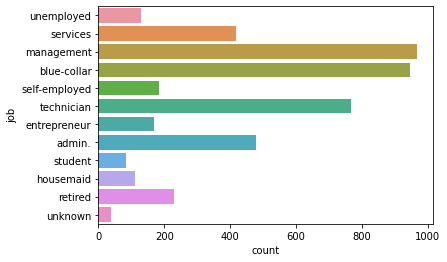

In [49]:
sns.countplot(y=df.job)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


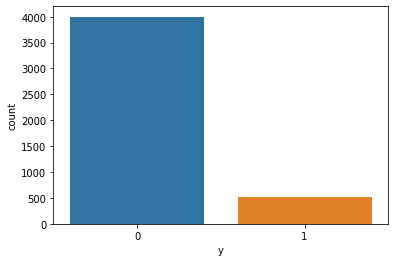

In [50]:
sns.countplot(df.y)

In [51]:
df.groupby('y').agg({'balance':'mean', 'age':'mean','default':'count'})

,balance,age,default
y,,,
0,1403.211750,40.998000,4000
1,1571.955854,42.491363,521


In [52]:
scipy.stats.ttest_ind(df.query('y==1').balance, df.query('y==0').balance)

Ttest_indResult(statistic=1.2038365069717434, pvalue=0.22871583038630486)

In [53]:
scipy.stats.ttest_ind(df.query('y==1').age, df.query('y==0').age)

Ttest_indResult(statistic=3.034315524024384, pvalue=0.002424535817380578)

In [54]:
help_df = df.groupby('job').agg({'age':'mean','day':'mean','duration':'mean','balance': 'mean','y':'sum', 'default':'count'})

In [55]:
help_df['proportion'] = help_df.y/help_df.default

In [56]:
help_df

,age,day,duration,balance,y,default,proportion
job,,,,,,,
admin.,39.682008,16.324268,234.669456,1226.736402,58,478,0.121339
blue-collar,40.156448,15.482030,278.161734,1085.161734,69,946,0.072939
entrepreneur,42.011905,15.255952,285.476190,1645.125000,15,168,0.089286
housemaid,47.339286,15.294643,292.633929,2083.803571,14,112,0.125000
management,40.540764,16.254902,260.536636,1766.928793,131,969,0.135191
retired,61.869565,15.556522,285.656522,2319.191304,54,230,0.234783
self-employed,41.453552,16.180328,264.125683,1392.409836,20,183,0.109290
services,38.570743,15.515588,262.486811,1103.956835,38,417,0.091127
student,26.821429,16.392857,248.690476,1543.821429,19,84,0.226190


In [57]:
help_df.query('proportion>=0.10').balance.median(), help_df.query('proportion<0.10').balance.median()

(1501.7105263157894, 1103.9568345323742)

In [58]:
help_df.query('proportion>=0.10').balance.mean(), help_df.query('proportion<0.10').balance.mean()

(1583.8910921913878, 1278.081189382532)

In [59]:
scipy.stats.ttest_ind(df.query(f'job == {list(help_df.query("proportion>=0.10").index)}').balance,df.query(f'job == {list(help_df.query("proportion<0.10").index)}').balance)

Ttest_indResult(statistic=4.33978779948301, pvalue=1.4573592713021476e-05)

In [60]:
help_df.query('proportion>=0.10').default.median(), help_df.query('proportion<0.10').default.median()

(183.0, 417.0)

In [61]:
df.month = pd.to_datetime(df.month, format='%b').dt.month

In [62]:
scipy.stats.ttest_ind(df.query('y==0').pdays, df.query('y==1').pdays)

Ttest_indResult(statistic=-7.035295328271235, pvalue=2.2870712487189066e-12)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


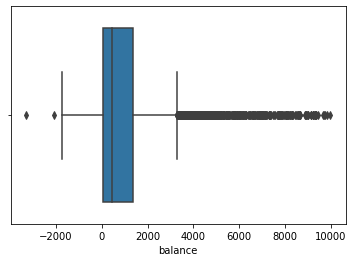

In [63]:
sns.boxplot(df.query('balance<10000').balance)

In [64]:
df.query('balance>10000').groupby('y').agg({'default':'count'})

,default
y,
0,87
1,5


In [65]:
df.drop(df.query('balance>10000').index, inplace=True)

In [66]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,10,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,5,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,4,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,6,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,5,226,1,-1,0,unknown,0


In [67]:
df.groupby('marital').agg({'y':'sum', 'default':'count'})

,y,default
marital,,
divorced,77,523
married,275,2740
single,164,1166


In [68]:
df.groupby('poutcome').agg({'y':'sum', 'default':'count'})

,y,default
poutcome,,
failure,62,478
other,38,194
success,83,125
unknown,333,3632


In [69]:
df.groupby('education').agg({'y':'sum', 'default':'count', 'balance':'median'})

,y,default,balance
education,,,
primary,62,669,389.0
secondary,244,2269,368.0
tertiary,191,1309,544.0
unknown,19,182,553.5


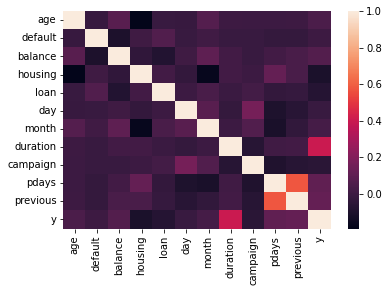

In [70]:
sns.heatmap(df.corr())

In [71]:
df.groupby('y').agg({'y':'sum', 'default':'count'})

,y,default
y,,
0,0,3913
1,516,516


In [72]:
df = pd.get_dummies(df)

In [73]:
X = df.drop(['y'], axis=1)
y = df.y

In [74]:
ada = ADASYN()
X_ada, y_ada = ada.fit_resample(X,y)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_ada,y_ada, test_size=0.2)

In [76]:
y_train.value_counts()

1    3144
0    3133
Name: y, dtype: int64

In [77]:
rf = RandomForestClassifier()
cross_val_score(rf, X, y, scoring='roc_auc',cv = 10)

array([0.91163966, 0.90136054, 0.90106042, 0.87468031, 0.92410978,
       0.93229884, 0.89066496, 0.92310151, 0.87743459, 0.89867609])

In [78]:
cross_val_score(rf, X_ada, y_ada, scoring='roc_auc',cv = 10)

array([0.92255089, 0.97485655, 0.99952939, 0.999075  , 0.99835123,
       0.99941254, 0.99672193, 0.99747825, 0.9980672 , 0.99755634])